In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Exploration

In [2]:
df = pd.read_csv('data.csv')
print(f'Shape of data: {df.shape}')
df.head()

Shape of data: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.columns = ['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Score']

In [5]:
df.iloc[:, 2:].describe().round(2)

,Age,Annual Income,Spending Score
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


In [6]:
df.isna().sum().sum()

0

In [7]:
df.duplicated().sum()

0

## Data Visualization

Text(0.5, 1.0, 'Spending Score Distribution')

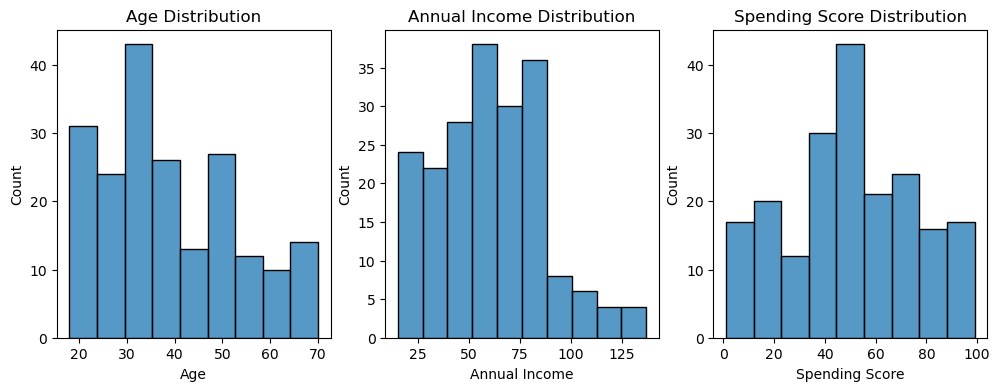

In [8]:
plt.figure(figsize=(12, 4))
plt.tight_layout(pad=5)

plt.subplot(1, 3, 1)
sns.histplot(x='Age', data=df).set_title('Age Distribution')

plt.subplot(1, 3, 2)
sns.histplot(x='Annual Income', data=df).set_title('Annual Income Distribution')

plt.subplot(1, 3, 3)
sns.histplot(x='Spending Score', data=df).set_title('Spending Score Distribution')

Summary:
<li>Most of the customers are under 50 years old with an annual income of under 78,000 USD.
<li>Spending score is on a scale of 0 to 100, mainly falling into the range [35, 55].

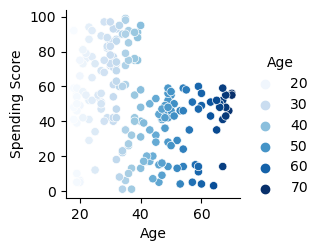

In [9]:
sns.pairplot(data=df, x_vars=['Age'], y_vars=['Spending Score'], hue='Age', palette='Blues')

There is a difference in spending scores among ages. While customers under 35 often spend a lot with Spending Score of above 40, older customers have lower spending scores, under 60.

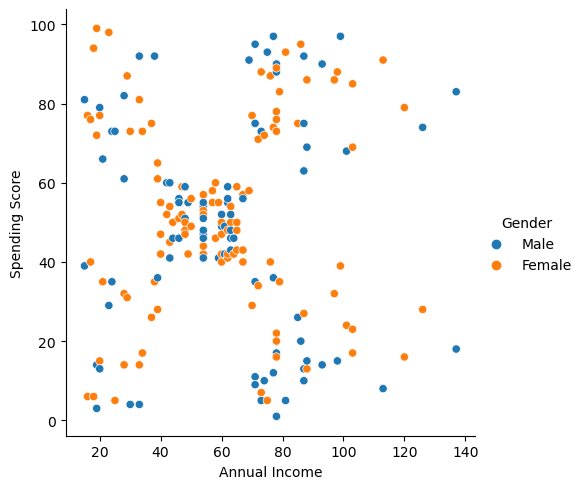

In [10]:
sns.relplot(x='Annual Income', y='Spending Score', data=df, kind='scatter', hue='Gender')

It appears to have 5 groups of customers with different behaviors based on annual income and spending score. We also do not observe a clear distinction regarding gender in this plot.

Text(0.5, 1.0, 'Spending Score by Gender')

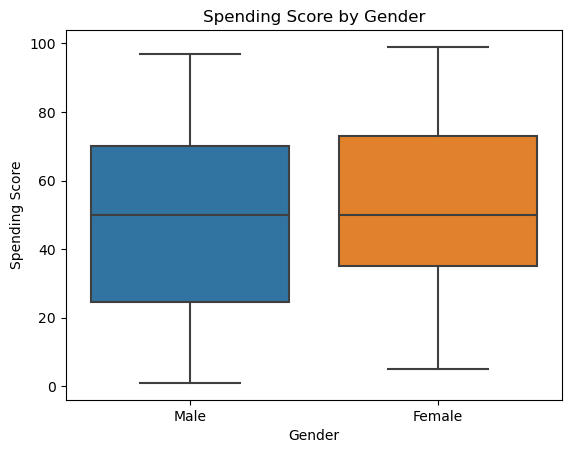

In [11]:
sns.boxplot(x='Gender', y='Spending Score', data=df).set_title('Spending Score by Gender')

This boxplot provides us with a slight difference in spending scores between males and females. They all have the same average spending score, but spending score for females seems higher than that for males.

# Clustering

In [21]:
features = df[['Gender', 'Age', 'Annual Income', 'Spending Score']].copy()

In [22]:
features = pd.get_dummies(features, columns=['Gender'])
features.head()

,Age,Annual Income,Spending Score,Gender_Female,Gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Determine the best clustering algorithm
bestSil = -1
for k in range(2, 6):
    print (f'k={k}')
    clus = [KMeans(n_clusters=k, n_init='auto'), 
            Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k), 
            SpectralClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(features)
        sil = silhouette_score(features, res.labels_)
        print (f"{(str(cl).split('(')[0]+'   ')[:8]} with k={str(k)}: {str(round(sil,4))}")
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl
            bestK = k
print('***********************************************')
print ('Best algorithm is....... ' + str(bestCl).split('(')[0][:6] + ' with k=' + str(bestK))
print('************************')
print ('With Silhouette Score of ' + str(round(bestSil, 4)))

k=2
KMeans   with k=2: 0.2729
Birch    with k=2: 0.2984
Agglomer with k=2: 0.2991
Spectral with k=2: 0.3908
k=3
KMeans   with k=3: 0.3218
Birch    with k=3: 0.3837
Agglomer with k=3: 0.3812
Spectral with k=3: 0.3908
k=4
KMeans   with k=4: 0.4054
Birch    with k=4: 0.4121
Agglomer with k=4: 0.41
Spectral with k=4: 0.3908
k=5
KMeans   with k=5: 0.4438
Birch    with k=5: 0.4406
Agglomer with k=5: 0.4398
Spectral with k=5: 0.3908
***********************************************
Best algorithm is....... KMeans with k=5
************************
With Silhouette Score of 0.4438


In [25]:
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=0)
kmeans.fit(features)

KMeans(n_clusters=5, n_init='auto', random_state=0)

In [26]:
features['Cluster'] = kmeans.labels_+1
features.head(5)

,Age,Annual Income,Spending Score,Gender_Female,Gender_Male,Cluster
0,19,15,39,0,1,4
1,21,15,81,0,1,4
2,20,16,6,1,0,3
3,23,16,77,1,0,4
4,31,17,40,1,0,3


In [27]:
# Get summary information on the clusters' characteristics
features.groupby('Cluster').mean()

,Age,Annual Income,Spending Score,Gender_Female,Gender_Male
Cluster,,,,,
1,41.647059,88.735294,16.764706,0.441176,0.558824
2,33.396226,58.056604,48.773585,0.641509,0.358491
3,54.060000,40.460000,36.720000,0.560000,0.440000
4,25.250000,25.833333,76.916667,0.583333,0.416667
5,32.692308,86.538462,82.128205,0.538462,0.461538


Eyeballing the results, we realize the difference among customer groups mainly originates from values of annual income and spending score.
<br>Therefore, customers are divided into 5 groups as below:
<li>Cluster 1: Customers have a high annual income but a low spending score.
<li>Cluster 2: Customers have a medium-high annual income and spending score.
<li>Cluster 3: Customers have a low-medium annual income and spending score.
<li>Cluster 4: Customers have a low annual income but high spending score.
<li>Cluster 5: Customers have a high annual income and spending score.

## Dimensionality Reduction

Now we will use PCA (Principal Component Analysis) and t-SNE (t-distributed stochastic neighbor embedding) to reduce the dimensionality of the dataset for visualization. To do that, we need to convert the features from a 5-dimensional space to a 2-dimensional space.

In [28]:
# PCA with 2 components
pca = PCA(n_components=2).fit_transform(features)
features['PCA1'] = pca[:, 0]
features['PCA2'] = pca[:, 1]

# TSNE with 2 components
tsne = TSNE(n_components=2).fit_transform(features)
features['TSNE1'] = tsne[:, 0]
features['TSNE2'] = tsne[:, 1]

Text(0.5, 1.0, 'Visualization using TSNE')

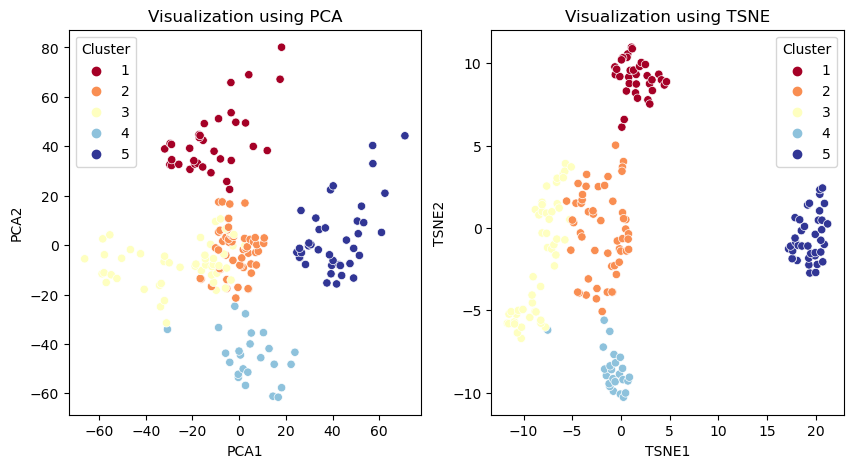

In [29]:
plt.figure(figsize=(10, 5))
plt.tight_layout(pad=5)

plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', data=features, hue='Cluster', palette='RdYlBu').set_title('Visualization using PCA')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', data=features, hue='Cluster', palette='RdYlBu').set_title('Visualization using TSNE')

Although there is some overlap between clusters 2 and 3 from visualization using PCA, the separation among 5 clusters is clear by the TSNE method. Therefore, categorizing customers into 5 groups makes sense.